<a href="https://colab.research.google.com/github/junwin/colab/blob/main/PreProcWork.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Dependancies
import pandas as pd
! pip install tensorflow==2.4.0
# TensorFlow is an open source machine learning library
import tensorflow as tf

# Keras is TensorFlow's high-level API for deep learning
from tensorflow import keras
from tensorflow.keras import regularizers
# Numpy is a math library
import numpy as np
# Pandas is a data manipulation library 
import pandas as pd
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# Math is Python's math library
import math
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler,StandardScaler


from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
url="https://junwin.github.io/HouseData3.csv"
rawData=pd.read_csv(url).sample(frac=1)
rawData.describe()



,MLS#,YearClosed,SoldPr,Locale,Zip,Area,Rooms,FullBaths,HalfBaths,Beds,BsmtBeds,GarageSpaces,ParkingSpaces
count,9.605000e+03,9605.000000,9.605000e+03,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000,9605.000000
mean,1.037041e+07,2019.130765,4.643093e+05,78.721603,60079.478605,2222.006767,7.968974,2.225299,0.549922,3.222957,0.144300,1.660718,0.409787
std,3.808318e+05,0.948912,3.246592e+05,59.308417,67.705670,1243.632265,2.500578,0.987977,0.578789,1.033955,0.388828,1.342160,3.543110
min,8.866215e+06,2017.000000,2.500000e+04,2.000000,60002.000000,372.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.013837e+07,2019.000000,2.600000e+05,53.000000,60053.000000,1344.000000,6.000000,2.000000,0.000000,3.000000,0.000000,1.000000,0.000000
50%,1.043821e+07,2019.000000,3.650000e+05,62.000000,60062.000000,1868.000000,8.000000,2.000000,1.000000,3.000000,0.000000,2.000000,0.000000
75%,1.067198e+07,2020.000000,5.750000e+05,76.000000,60077.000000,2750.000000,9.000000,3.000000,1.000000,4.000000,0.000000,2.000000,0.000000
max,1.095755e+07,2021.000000,4.300000e+06,201.000000,63104.000000,17365.000000,18.000000,8.000000,5.000000,11.000000,3.000000,79.000000,308.000000


In [3]:
dataframe = rawData[['YearClosed', 'Type', 'Area', 'Zip', 'Rooms','FullBaths','Beds','GarageSpaces']]
prices = rawData['SoldPr']
SAMPLES = len(dataframe.index)
featureCount = len(dataframe.columns)
dataframe['target'] = rawData['SoldPr']/100000.00
dataframe['Area'] = rawData['Area']/1000.00

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [4]:
val_dataframe = dataframe.sample(frac=0.2, random_state=1337)
train_dataframe = dataframe.drop(val_dataframe.index)

print(
    "Using %d samples for training and %d for validation"
    % (len(train_dataframe), len(val_dataframe))
)


Using 7684 samples for training and 1921 for validation


In [5]:
def dataframe_to_dataset(dataframe):
    dataframe = dataframe.copy()
    labels = dataframe.pop("target")
    ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
    ds = ds.shuffle(buffer_size=len(dataframe))
    return ds


train_ds = dataframe_to_dataset(train_dataframe)
val_ds = dataframe_to_dataset(val_dataframe)


In [6]:
for x, y in train_ds.take(1):
    print("Input:", x)
    print("Target:", y)


Input: {'YearClosed': <tf.Tensor: shape=(), dtype=int64, numpy=2019>, 'Type': <tf.Tensor: shape=(), dtype=string, numpy=b'Townhouse'>, 'Area': <tf.Tensor: shape=(), dtype=float64, numpy=2.182>, 'Zip': <tf.Tensor: shape=(), dtype=int64, numpy=60026>, 'Rooms': <tf.Tensor: shape=(), dtype=int64, numpy=9>, 'FullBaths': <tf.Tensor: shape=(), dtype=int64, numpy=3>, 'Beds': <tf.Tensor: shape=(), dtype=float64, numpy=3.0>, 'GarageSpaces': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>}
Target: tf.Tensor(5.6, shape=(), dtype=float64)


In [7]:
train_ds = train_ds.batch(1000)
val_ds = val_ds.batch(1000)


In [8]:
from tensorflow.keras.layers.experimental.preprocessing import Normalization
from tensorflow.keras.layers.experimental.preprocessing import CategoryEncoding
from tensorflow.keras.layers.experimental.preprocessing import StringLookup


def encode_numerical_feature(feature, name, dataset):
    # Create a Normalization layer for our feature
    normalizer = Normalization()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the statistics of the data
    normalizer.adapt(feature_ds)

    # Normalize the input feature
    encoded_feature = normalizer(feature)
    return encoded_feature


def encode_string_categorical_feature(feature, name, dataset):
    # Create a StringLookup layer which will turn strings into integer indices
    index = StringLookup()

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the set of possible string values and assign them a fixed integer index
    index.adapt(feature_ds)

    # Turn the string input into integer indices
    encoded_feature = index(feature)

    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a dataset of indices
    feature_ds = feature_ds.map(index)

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(encoded_feature)
    return encoded_feature


def encode_integer_categorical_feature(feature, name, dataset):
    # Create a CategoryEncoding for our integer indices
    encoder = CategoryEncoding(output_mode="binary")

    # Prepare a Dataset that only yields our feature
    feature_ds = dataset.map(lambda x, y: x[name])
    feature_ds = feature_ds.map(lambda x: tf.expand_dims(x, -1))

    # Learn the space of possible indices
    encoder.adapt(feature_ds)

    # Apply one-hot encoding to our indices
    encoded_feature = encoder(feature)
    return encoded_feature


In [9]:
#selectedFeatures = rawData[['YearClosed', 'Type', 'Area', 'Zip', 'Rooms','FullBaths','Beds','GarageSpaces']]

# Categorical features encoded as integers
YearClosed = keras.Input(shape=(1,), name="YearClosed", dtype="int64")
Zip = keras.Input(shape=(1,), name="Zip", dtype="int64")

# Categorical feature encoded as string
Type = keras.Input(shape=(1,), name="Type", dtype="string")

# Numerical features
Area = keras.Input(shape=(1,), name="Area")
Rooms = keras.Input(shape=(1,), name="Rooms")
FullBaths = keras.Input(shape=(1,), name="FullBaths")
Beds = keras.Input(shape=(1,), name="Beds")
GarageSpaces = keras.Input(shape=(1,), name="GarageSpaces")

all_inputs = [
    #YearClosed,
    #Zip,
    #Type,
    Area,
    Rooms,
    FullBaths,
    Beds,
    GarageSpaces,
]


In [29]:
# Integer categorical features
YearClosed_encoded = encode_integer_categorical_feature(YearClosed, "YearClosed", train_ds)
Zip_encoded = encode_integer_categorical_feature(Zip, "Zip", train_ds)

# String categorical features
Type_encoded = encode_string_categorical_feature(Type, "Type", train_ds)

# Numerical features
Area_encoded = encode_numerical_feature(Area, "Area", train_ds)
Rooms_encoded = encode_numerical_feature(Rooms, "Rooms", train_ds)
FullBaths_encoded = encode_numerical_feature(FullBaths, "FullBaths", train_ds)
Beds_encoded = encode_numerical_feature(Beds, "Beds", train_ds)
GarageSpaces_encoded = encode_numerical_feature(GarageSpaces, "GarageSpaces", train_ds)


all_features = layers.concatenate(
    [
    #YearClosed_encoded,
    #Zip_encoded,
    #Type_encoded,
    Area_encoded,
    Rooms_encoded,
    FullBaths_encoded,
    Beds_encoded,
    GarageSpaces_encoded
    ])

all_features = layers.concatenate(
    [
    #YearClosed_encoded,
    #Zip_encoded,
    #Type_encoded,
    Area,
    Rooms,
    FullBaths,
    Beds,
    GarageSpaces
    ])


In [30]:
model_1 = tf.keras.Sequential()
layers.Dense(16, activation="relu")(all_features)
model_1.add(layers.Dense(16, activation="relu")(all_features))
#model_1.add(keras.layers.Dense(16, activation='relu', input_shape=(all_features.shape)))
#model_1.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001), input_shape=(featureCount,)))
model_1.add(keras.layers.Dense(16, activation='relu'))
#model_1.add(keras.layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.001)))
model_1.add(keras.layers.Dense(1))

# Compile the model using the standard 'adam' optimizer and the mean squared error or 'mse' loss function for regression.
model_1.compile(optimizer='adam', loss='mse', metrics=['mae'])
keras.utils.plot_model(model_1, show_shapes=True, rankdir="LR")

TypeError: ignored

In [27]:
zzz = dataframe[['Area', 'Rooms','FullBaths','Beds','GarageSpaces', 'target']]
tt = dataframe_to_dataset(zzz)
vv = dataframe_to_dataset(zzz)
vv = vv.batch(500)
for x, y in tt.take(1):
    print("Input:", x)
    print("Target:", y)

history_1 = model_1.fit(vv, epochs=500)

Input: {'Area': <tf.Tensor: shape=(), dtype=float64, numpy=1.0>, 'Rooms': <tf.Tensor: shape=(), dtype=int64, numpy=5>, 'FullBaths': <tf.Tensor: shape=(), dtype=int64, numpy=1>, 'Beds': <tf.Tensor: shape=(), dtype=float64, numpy=2.0>, 'GarageSpaces': <tf.Tensor: shape=(), dtype=float64, numpy=0.0>}
Target: tf.Tensor(1.32, shape=(), dtype=float64)
Epoch 1/500


ValueError: ignored

In [25]:
x = layers.Dense(16, activation="relu")(all_features)
x = layers.Dense(16, activation="relu")(x)
output = layers.Dense(1, activation="relu")(x)
model = keras.Model(all_inputs, output)
model.compile(optimizer='adam', loss='mse', metrics=["mae"])

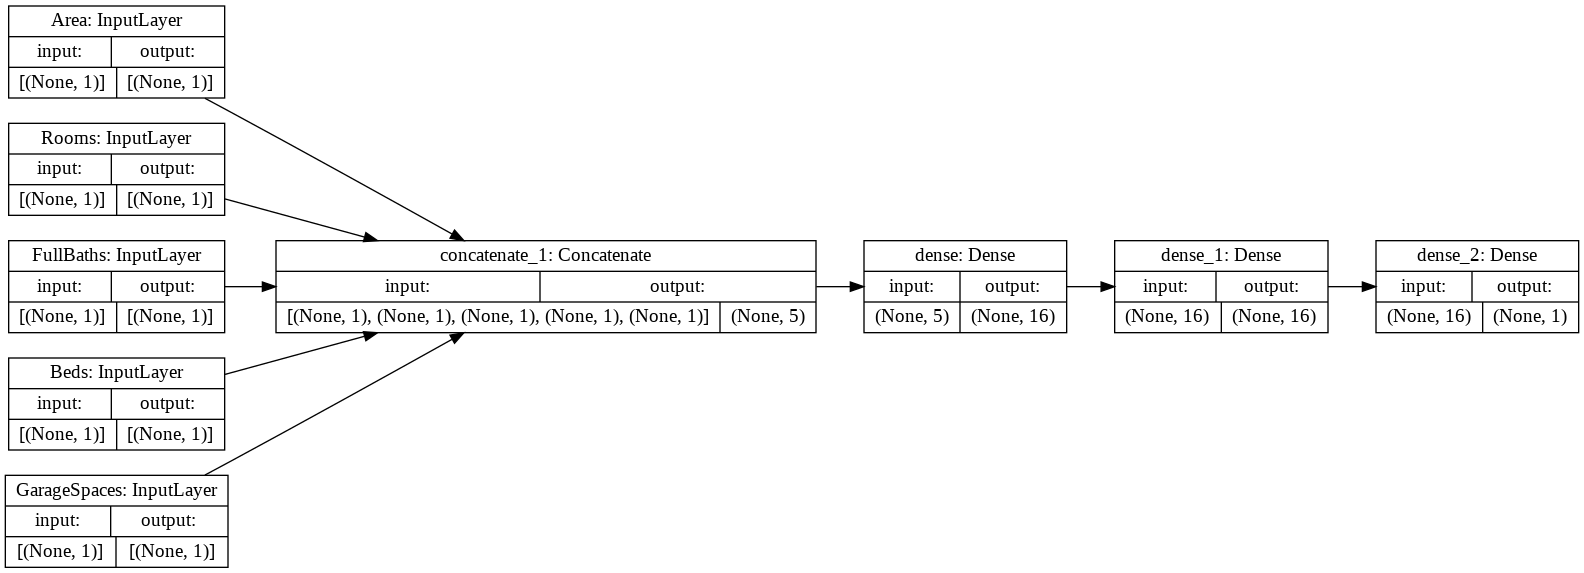

In [26]:
# `rankdir='LR'` is to make the graph horizontal.
keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

In [27]:
history_1 = model.fit(train_ds, epochs=50,  validation_data=val_ds)

Epoch 1/50


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/functional.py:595: UserWarning: Input dict contained keys ['YearClosed', 'Type', 'Zip'] which did not match any model input. They will be ignored by the model.
  [n for n in tensors.keys() if n not in ref_input_names])


8/8 [==============================] - 1s 34ms/step - loss: 70.7368 - mae: 6.7633 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 2/50
8/8 [==============================] - 0s 14ms/step - loss: 32.5274 - mae: 4.6513 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 3/50
8/8 [==============================] - 0s 13ms/step - loss: 32.8508 - mae: 4.6509 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 4/50
8/8 [==============================] - 0s 13ms/step - loss: 32.0245 - mae: 4.6309 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 5/50
8/8 [==============================] - 0s 15ms/step - loss: 31.9735 - mae: 4.6227 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 6/50
8/8 [==============================] - 0s 14ms/step - loss: 31.9177 - mae: 4.6354 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 7/50
8/8 [==============================] - 0s 15ms/step - loss: 31.9517 - mae: 4.6273 - val_loss: 31.7704 - val_mae: 4.6911
Epoch 8/50
8/8 [==============================] - 0s 13ms/step - loss: 32.5013 - mae: 4.6548 -

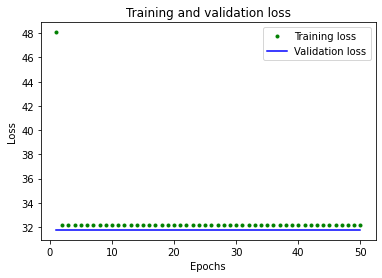

In [28]:
# Draw a graph of the loss, which is the distance between
# the predicted and actual values during training and validation.
train_loss = history_1.history['loss']
val_loss = history_1.history['val_loss']
epochs = range(1, len(train_loss) + 1)

plt.plot(epochs, train_loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()